In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import sys 
from numpy import trapz
from scipy import interp

%matplotlib inline

In [2]:
# Get the required files
df_sig = pd.read_hdf('mc16ae_Honly_sig_NN_var.h5', 'df_sig')
df_bkg2 = pd.read_hdf('mc16a_qZZ_bkg_NN_var.h5','df_bkg2')
#get 1 jet events
df_sig1j = df_sig[df_sig['n_jets']==1]
df_bkg21j = df_bkg2[df_bkg2['n_jets']==1]

In [3]:
#define the discriminant
df_sig['ME_disc_0j'] = np.log10(df_sig['ggHZZ_ME_0j']/(df_sig['ggZZ_ME_0j']+0.1*df_sig['qqZZ_ME_0j']))
df_bkg2['ME_disc_0j'] = np.log10(df_bkg2['ggHZZ_ME_0j']/(df_bkg2['ggZZ_ME_0j']+0.1*df_bkg2['qqZZ_ME_0j']))

In [4]:
# names of event-level branches
npart = ["ME_disc_0j","m4l_unconstrained","cos_theta_str","cos_theta_1","pt4l_fsr","phi","phi_1","Z1_m","Z2_m","n_jets"]

In [5]:
df= pd.concat((df_sig[npart], df_bkg2[npart]), ignore_index=True)

X = df.as_matrix()
w =  pd.concat((df_sig['weight'], df_bkg2['weight']), ignore_index=True).values
y = []
for _df, ID in [(df_sig, 0), (df_bkg2, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [6]:
ix = range(X.shape[0])
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.4)

/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
inputs = Input(shape=(X_train.shape[1], )) # placeholder

hidden = Dense(2, activation='relu')(inputs)
#hidden = Dropout(0.2)(hidden)
#hidden = Dense(20, activation='relu')(hidden)
#hidden = Dropout(0.2)(hidden)
#hidden = Dense(30, activation='relu')(hidden)
#hidden = Dropout(0.2)(hidden)
outputs = Dense(2, activation='sigmoid')(hidden)
# last layer has to have the same dimensionality as the number of classes we want to predict, here 3

model = Model(inputs, outputs)
model.summary()
plot_model(model, 'temp.png', show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
from collections import Counter
Counter(y_test)

Counter({0: 17422, 1: 25789})

In [11]:
print ('Training:')
try:
    history = model.fit(
        X_train, y_train, 
        class_weight={ # rebalance class representation
            0 : 0.40 * (float(len(y)) / (y == 0).sum()),
            1 : 0.60 * (float(len(y)) / (y == 1).sum()), },
        callbacks = [
            EarlyStopping(verbose=True, patience=15, monitor='val_loss'),
            ModelCheckpoint('./tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=100, 
        validation_split = 0.5,
        batch_size=100,
        verbose=False)
except KeyboardInterrupt:
    print('Training ended early.')

Training:
Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.69164, saving model to ./tutorial-progress.h5

Epoch 00002: val_loss improved from 0.69164 to 0.67860, saving model to ./tutorial-progress.h5

Epoch 00003: val_loss improved from 0.67860 to 0.66818, saving model to ./tutorial-progress.h5

Epoch 00004: val_loss improved from 0.66818 to 0.63548, saving model to ./tutorial-progress.h5

Epoch 00005: val_loss improved from 0.63548 to 0.57577, saving model to ./tutorial-progress.h5

Epoch 00006: val_loss improved from 0.57577 to 0.53369, saving model to ./tutorial-progress.h5

Epoch 00007: val_loss improved from 0.53369 to 0.51090, saving model to ./tutorial-progress.h5

Epoch 00008: val_loss improved from 0.51090 to 0.49886, saving model to ./tutorial-progress.h5

Epoch 00009: val_loss improved from 0.49886 to 0.49216, saving model to ./tutorial-progress.h5

Epoch 00010: val_loss improved from 0.49216 to 0.48818, saving model to ./tutoria

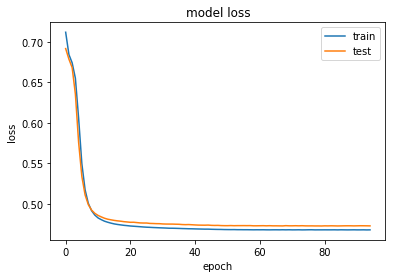

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
# -- load in best network
model.load_weights('./tutorial-progress.h5')
# -- Save network weights and structure
print( 'Saving model...')
model.save_weights('./tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./tutorial.json', 'w').write(json_string)
print ('Done')

Saving model...
Done


In [14]:
print ('Testing...')
yhat = model.predict(X_test, verbose = True, batch_size = 400)

Testing...
43211/43211 [==============================] - 0s 2us/step


In [15]:
yhat_sig=[]
yhat_sig.clear()
for i in range(0, 43211):
    yhat_sig.append(yhat[i][0])


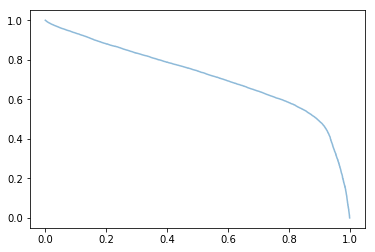

In [16]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fpr, tpr, thresholds = roc_curve(y_test, yhat_sig)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, 1-tpr, alpha=0.5, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

In [17]:
a = np.linspace(0,1,100)
#print(a)
sig_eff = []
b_rej = []
yhat_cls_1=[]
for j in a:
    for i in range(0, 411):
        if yhat[i][0]>j:
            yhat_cls_1.append(0)
        else:
            yhat_cls_1.append(1)
    yhat_cls = np.array(yhat_cls_1)
    yhat_cls_1.clear()
    #print(w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum())
    #print(1- w_test[(y_test == 1) & (yhat_cls == 0)].sum() / w_test[y_test == 1].sum())
    sig_eff.append(w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum())
    # bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
    b_rej.append(1 - w_test[(y_test == 1) & (yhat_cls == 0)].sum() / w_test[y_test == 1].sum())

ValueError: operands could not be broadcast together with shapes (43211,) (411,) 

In [ ]:
w_test_sig= w_test[(y_test == 0)]
w_test_bkg= w_test[(y_test == 1)]

w_test_bkg[:-1]
w_test_bkg2= w_test_bkg[:-1].copy()

In [ ]:
yhat_sig=[]
yhat_sig.clear()
n=0
for i in y_test:
    n=n+1
    if n<43211:
        #print (i)
        if i==0:
            if yhat[n][0] <0.72:
                yhat_sig.append(yhat[n][0])
            #print ("signal = ", yhat[n][0] )
       

In [ ]:
yhat_bkg=[]
yhat_bkg.clear()
n=0
for i in y_test:
    #print(n)
    n=n+1
    if n<43211:
        if i==1:
            if yhat[n][1]> 0.09:
                yhat_bkg.append(yhat[n][1])
            #print ("bkg = ", yhat[n][0] )

In [ ]:
ax = plt.subplot(111)
plt.hist(yhat_sig, bins=50, density =True, label="signal")

plt.hist(yhat_bkg, bins=50, density =True, label="background")
plt.xlim([0, 1])
plt.ylim([0, 4])
plt.ylabel('Events')
plt.xlabel('NN score')
ax.legend()
plt.show()


In [ ]:
df_sig['ME_disc_0j'] = np.log10(df_sig['ggHZZ_ME_0j']/(df_sig['ggZZ_ME_0j']+0.1*df_sig['qqZZ_ME_0j']))
df_bkg2['ME_disc_0j'] = np.log10(df_bkg2['ggHZZ_ME_0j']/(df_bkg2['ggZZ_ME_0j']+0.1*df_bkg2['qqZZ_ME_0j']))
(n_sig, bins_sig, patches_sig) = plt.hist(df_sig['ME_disc_0j'],range=(-5, 0), bins=30, label='hst', weights=df_sig['weight'])
(n_bkg, bins_bkg, patches_bkg) = plt.hist(df_bkg2['ME_disc_0j'], range=(-5, 0), bins=30, label='hst', weights=df_bkg2['weight'])
a = np.linspace(-5, 0, 30)
sig_eff_old = []
bkg_rej_old = []
total_sig=0
total_bkg=0
for sig in n_sig:
    total_sig = total_sig+sig
for bkg in n_bkg:
    total_bkg = total_bkg+bkg

for j in a:
    TP=0
    FP =0
    for i in range(0, 30):
        if bins_sig[i]>j:
            TP=TP+n_sig[i]
            FP=FP+n_bkg[i]
    sig_eff_old.append(TP/total_sig)
    bkg_rej_old.append(1-(FP/total_bkg))
    

In [ ]:
plt.figure()
plt.title('ROC Curve')
#plt.plot(sig_eff, b_rej,  label = 'NN discriminant')
plt.plot(sig_eff_old, bkg_rej_old, label ='0 jet ME Disc')
plt.legend(loc = 'lower left')

plt.xlim([0.2, 1])
plt.ylim([0, 1.05])
plt.ylabel('bkg rejection')
plt.xlabel('sig efficiency')
plt.show()